In [3]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, ReLU
from keras import backend
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

In [5]:
path='/Users/nihaalnadaf/Downloads/equity/'
X = pd.read_csv(path + "calls_data.csv")
y = pd.read_csv(path + "calls_target.csv")

# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Initial Model

In [8]:
# hyperparameters
n_units = 100
hidden_layers = 3 
batch_size = 1024
epochs = 10

# input layer
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(ReLU())

# hidden layers
for _ in range(hidden_layers):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(ReLU())

# output layer
model.add(Dense(1, activation='relu'))

optimizer = SGD()
model.compile(loss='mse', optimizer=optimizer)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
mlp1 = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 verbose=1)
     

Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 111298.7422 - val_loss: 112185.6875
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 111711.2188 - val_loss: 112185.6875
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 110395.9844 - val_loss: 112185.6875
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 110028.3359 - val_loss: 112185.6875
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 110714.1094 - val_loss: 112185.6875
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 108897.9531 - val_loss: 112185.6875
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 110996.1094 - val_loss: 112185.6875
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 111515.7188 - val_loss: 112185.6875
Epoch 9/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 112590.5547 - val_loss: 112185.6875
Epoch 10/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 109790.8047 - val_loss: 112185.6875


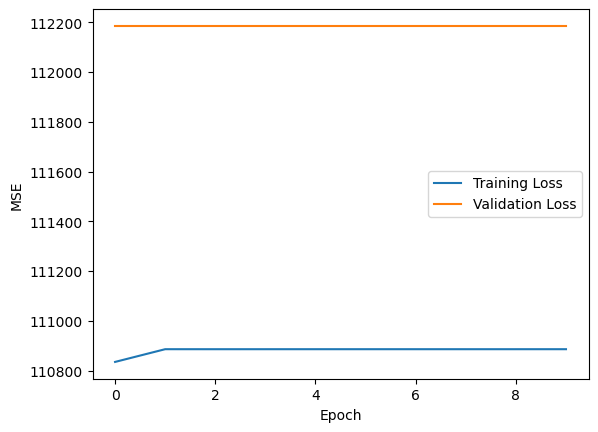

In [12]:
plt.plot(mlp1.history['loss'])
plt.plot(mlp1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [14]:
model.evaluate(X_test, y_test)
     


2515/2515 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - loss: 111981.9062


112099.09375

## Hyperparameter Optimization

In [18]:
def model_builder(hp):
  model = Sequential()

  # hyperparameters in search space
  hp_units = hp.Int('units', min_value=100, max_value=500, step=100)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'softmax'])
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

  model.add(Dense(hp_units, input_dim=X_train.shape[1]))
  
  # activation function
  if hp_activation == 'relu':
    activation_function = tf.keras.layers.ReLU()
  elif hp_activation == 'leaky_relu':
    activation_function = tf.keras.layers.LeakyReLU()
  elif hp_activation == 'softmax':
    activation_function = tf.keras.layers.Softmax()
  model.add(activation_function)
  for _ in range(3):
    model.add(Dense(n_units))
    model.add(activation_function)

  # output layer
  model.add(Dense(1, activation='relu'))

  # optimizer
  optimizer = Adam(learning_rate=hp_learning_rate)
  if hp_optimizer  == 'adam':
    optimizer = Adam(learning_rate=hp_learning_rate)
  if hp_optimizer  == 'sgd':
    optimizer = SGD(learning_rate=hp_learning_rate)
  if hp_optimizer  == 'rmsprop':
    optimizer = RMSprop(learning_rate=hp_learning_rate)
  model.compile(loss='mse', optimizer=hp_optimizer)

  return model

In [20]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hp_tuning',
                     project_name='mlp_call')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 100, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu', 'softmax'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
tuner.search(X_train, y_train, epochs=5, validation_split=0.1, callbacks=[stop_early])

Trial 26 Complete [00h 01m 27s]
val_loss: 112185.7109375

Best val_loss So Far: 78810.34375
Total elapsed time: 00h 07m 40s


In [26]:
# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]

print('Number of hidden units: ', best_hps.get('units'))
print('Learning rate         : ', best_hps.get('learning_rate'))
print('Activation function   : ', best_hps.get('activation'))
print('Optimizer             : ', best_hps.get('optimizer'))

Number of hidden units:  500
Learning rate         :  0.01
Activation function   :  softmax
Optimizer             :  sgd


In [28]:
# build model with optimal hyperparameters and train it  
model = tuner.hypermodel.build(best_hps)
mlp2 = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8048/8048 ━━━━━━━━━━━━━━━━━━━━ 6s 670us/step - loss: 111216.5938 - val_loss: 113303.6250
Epoch 2/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 665us/step - loss: 111406.0312 - val_loss: 113303.6250
Epoch 3/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 657us/step - loss: 110666.8203 - val_loss: 113303.6250
Epoch 4/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 659us/step - loss: 110594.7031 - val_loss: 113303.6250
Epoch 5/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 661us/step - loss: 110374.2109 - val_loss: 113303.6250
Epoch 6/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 660us/step - loss: 111697.2188 - val_loss: 113303.6250
Epoch 7/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 651us/step - loss: 111673.8047 - val_loss: 113303.6250
Epoch 8/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 642us/step - loss: 108789.0391 - val_loss: 113303.6250
Epoch 9/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 654us/step - loss: 112868.1484 - val_loss: 113303.6250
Epoch 10/50
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 6s 691us/step - loss: 109803.4609 - val_loss: 113303.6250
Epoch 11/5

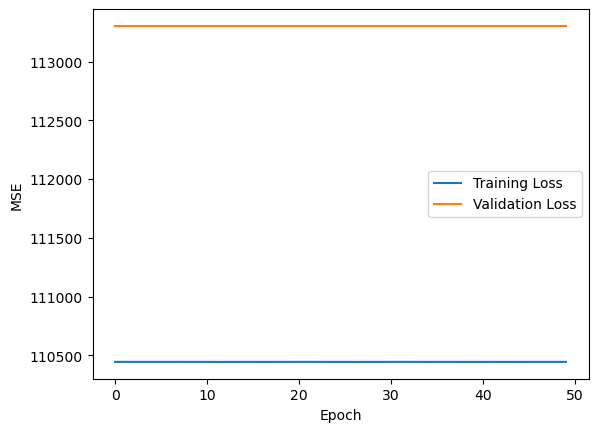

In [30]:
plt.plot(mlp2.history['loss'])
plt.plot(mlp2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
     

In [32]:
losses = mlp2.history['loss']
best_epochs = losses.index(min(losses))
best_epochs
     

11

In [34]:
# re-build model and train it with the optimal number of epochs
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=best_epochs, validation_split=0.2)

Epoch 1/11


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 667us/step - loss: 110938.8359 - val_loss: 113303.6250
Epoch 2/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 654us/step - loss: 110396.0234 - val_loss: 113303.6250
Epoch 3/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 660us/step - loss: 110474.3281 - val_loss: 113303.6250
Epoch 4/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 650us/step - loss: 111389.8047 - val_loss: 113303.6250
Epoch 5/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 659us/step - loss: 109796.2578 - val_loss: 113303.6250
Epoch 6/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 666us/step - loss: 112709.9766 - val_loss: 113303.6250
Epoch 7/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 658us/step - loss: 110021.2578 - val_loss: 113303.6250
Epoch 8/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 663us/step - loss: 111931.3594 - val_loss: 113303.6250
Epoch 9/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 666us/step - loss: 109331.5234 - val_loss: 113303.6250
Epoch 10/11
8048/8048 ━━━━━━━━━━━━━━━━━━━━ 5s 671us/step - loss: 110741.6250 - val_loss: 113303.6250
Epoch 11/1

In [36]:
model.evaluate(X_test, y_test)

2515/2515 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - loss: 111981.9062


112099.09375

In [38]:
# hyperparameters
n_units = 500
hidden_layers = 3 
batch_size = 4096
epochs = 11

# input layer
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(LeakyReLU())

# hidden layers
for _ in range(hidden_layers):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# output layer
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 500)            │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 774,001 (2.95 MB)

 Trainable params: 771,001 (2.94 MB)

 Non-trainable params: 3,000 (11.72 KB)

In [42]:
mlp3 = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 verbose=1)

Epoch 1/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 83672.5625 - val_loss: 159107.9375
Epoch 2/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 48896.1719 - val_loss: 52126.2969
Epoch 3/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 46741.3867 - val_loss: 52296.3008
Epoch 4/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 46677.9141 - val_loss: 49117.6172
Epoch 5/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 45008.8086 - val_loss: 50115.0586
Epoch 6/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 45044.0195 - val_loss: 47393.8242
Epoch 7/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 46091.6992 - val_loss: 49494.5273
Epoch 8/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 44237.9297 - val_loss: 50291.0234
Epoch 9/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 44493.7656 - val_loss: 65302.8320
Epoch 10/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 46484.9141 - val_loss: 50554.7422
Epoch 11/11
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 45352.53

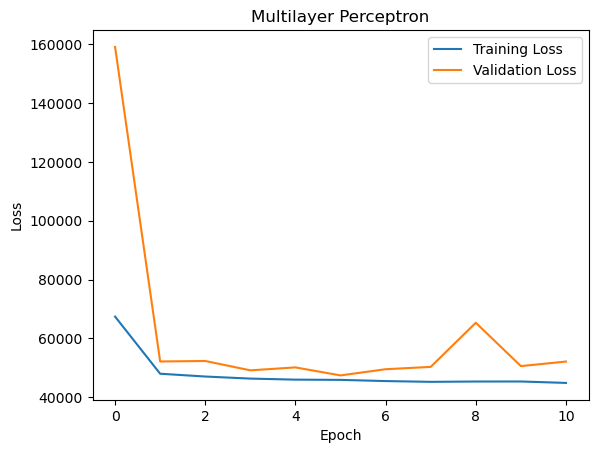

In [44]:
plt.plot(mlp3.history['loss'])
plt.plot(mlp3.history['val_loss'])
plt.title('Multilayer Perceptron')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
     

In [46]:
model.evaluate(X_test, y_test)

2515/2515 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - loss: 53188.2930


52715.01171875

In [50]:
model.save('/Users/nihaalnadaf/Documents/Derivative Pricing/model.keras')

## Retraining Model for Puts

In [63]:
# reading in data
X = pd.read_csv(path + "puts_data.csv")
y = pd.read_csv(path + "puts_target.csv")

# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
# hyperparameters
n_units = 500
hidden_layers = 3 
batch_size = 1024
epochs = 11

# input layer
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(LeakyReLU())

# hidden layers
for _ in range(hidden_layers):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# output layer
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
mlp4 = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 verbose=1)

Epoch 1/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 58959.4453 - val_loss: 49570.1016
Epoch 2/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 50150.6289 - val_loss: 55129.4102
Epoch 3/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47648.4727 - val_loss: 74293.9219
Epoch 4/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 46371.7852 - val_loss: 246351.4219
Epoch 5/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47065.8789 - val_loss: 57624.0273
Epoch 6/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 48425.5352 - val_loss: 53948.5703
Epoch 7/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 44532.9492 - val_loss: 53519.8359
Epoch 8/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 46551.9648 - val_loss: 48101.8984
Epoch 9/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 44950.9141 - val_loss: 61212.3281
Epoch 10/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 45456.3242 - val_loss: 52630.8008
Epoch 11/11
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms

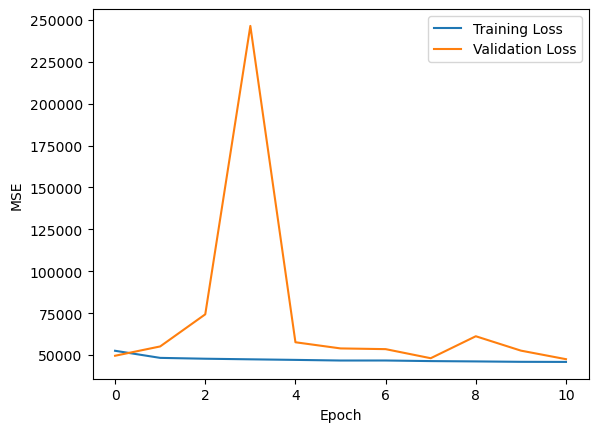

In [71]:
plt.plot(mlp4.history['loss'])
plt.plot(mlp4.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [73]:
model.evaluate(X_test, y_test)

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step - loss: 48766.0234


47887.75

In [75]:
model.save('/Users/nihaalnadaf/Documents/Derivative Pricing/model_MlP_put.keras')